# Lesson 6 - Random Forest

## Author - Lukas Fiorio

## Instructions

- Read data
- Explore the data
- Split data into train/validate/test
- Compare Rnadom Forest & Desicison Trees
  - Performance
  - Feature Importance
- Evaluate on the test set
- Summarize findings and make a recommendation

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn import tree
from IPython.display import display
from itertools import product

In [2]:
# set package options
pd.set_option('display.max_columns', None) # show all columns

### Load data

- note: headers in first row of csv

In [3]:
# read file into df
file = "https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/Bank%20Data.csv"
bank_df = pd.read_csv(file, header = 0)

Based on preview of the data, it looks like there are a couple of numeric fields (`age`, `income`, `children`), but mostly categorical.

In [4]:
bank_df.head() # preview data

,age,sex,region,income,married,children,car,save_act,current_act,mortgage,pep
0,48,FEMALE,INNER_CITY,17546.0,NO,1,NO,NO,NO,NO,YES
1,40,MALE,TOWN,30085.1,YES,3,YES,NO,YES,YES,NO
2,51,FEMALE,INNER_CITY,16575.4,YES,0,YES,YES,YES,NO,NO
3,23,FEMALE,TOWN,20375.4,YES,3,NO,NO,YES,NO,NO
4,57,FEMALE,RURAL,50576.3,YES,0,NO,YES,NO,NO,NO


We get confirmation here of object columns (other than `age`, `income`, `children`).  We also see no missing values.

In [5]:
bank_df.info() # examine data structure

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          600 non-null    int64  
 1   sex          600 non-null    object 
 2   region       600 non-null    object 
 3   income       600 non-null    float64
 4   married      600 non-null    object 
 5   children     600 non-null    int64  
 6   car          600 non-null    object 
 7   save_act     600 non-null    object 
 8   current_act  600 non-null    object 
 9   mortgage     600 non-null    object 
 10  pep          600 non-null    object 
dtypes: float64(1), int64(2), object(8)
memory usage: 51.7+ KB


Define a function to loop through and create count plots based on an inputted data frame & list of columns.

In [6]:
def count_plots(df, col_list, n_cols):
    
    # deduce nbr of rows needed for plot
    n_rows = math.ceil(len(col_list) / n_cols)

    # set figure, axis properties
    fig, ax = plt.subplots(ncols = n_cols, nrows = n_rows)
    fig.set_size_inches(16, 2.5 * n_rows)
    fig.tight_layout(h_pad = 6, w_pad = 12)

    # loop through each column & plot
    for i, col in enumerate(col_list):
        
        # compute row, col index
        i_row = math.floor(i/2)
        i_col = i % 2
        
        # make plots
        sns.countplot(y = df[col], ax = ax[i_row][i_col]); # check dist of target (continous)
        ax[i_row][i_col].title.set_text('# of cust, by ' + col);

Loop through object columns and visually inspect each of their distributions.

- We'll need to one-hot encode these columns.  Only `region` is not binary.
- We also notice that `pep` has relatively even class balance.

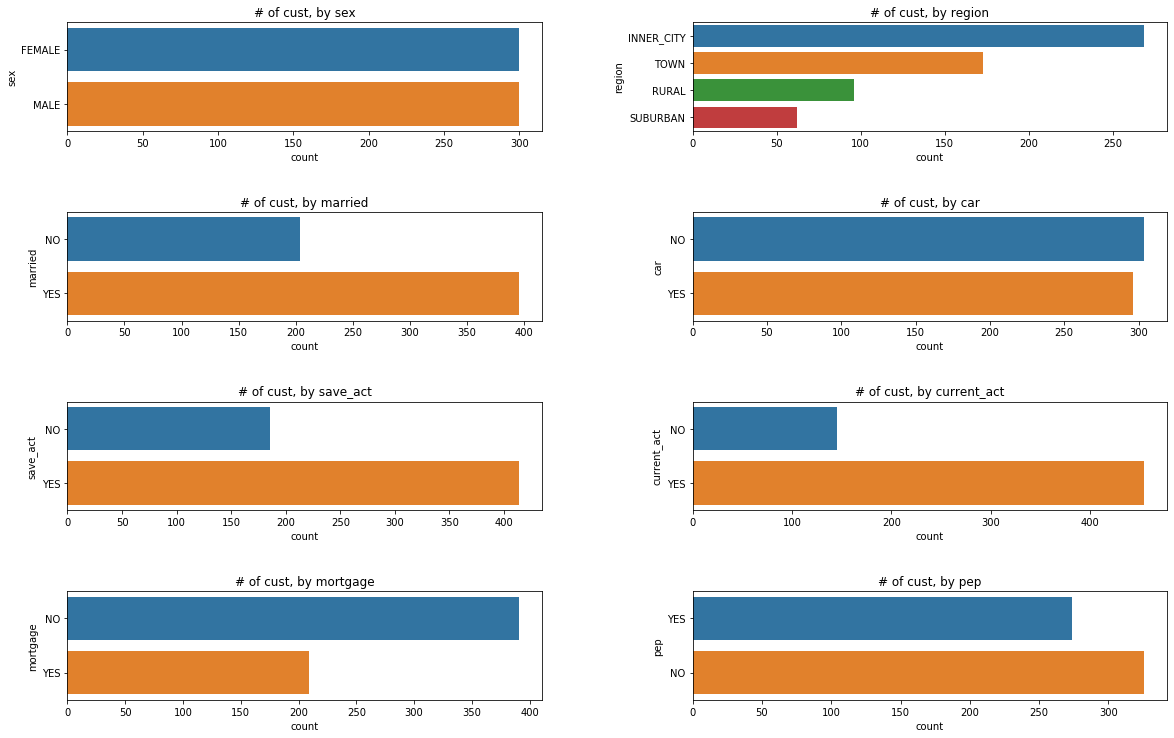

In [7]:
obj_cols = bank_df.select_dtypes('object').columns.to_list()
count_plots(bank_df, obj_cols, 2)

In this case, we will apply one hot encoding prior to splitting into train/validate/test sets because our data appear to fit a very pre-defined structure.  Normally, it is better practice to apply onehot encoding after splitting your data, in case new classes appear in the test set.

- Note `drop = 'first'` will drop the first class from each column (removes linear dependence).

In [8]:
# initialize class and fit our data (drop linearly dependent columns)
onehot = OneHotEncoder(sparse = False, drop = 'first') # initialize one-hot-encoder
onehot.fit(bank_df[obj_cols])

# properly name columns
onehot_names = onehot.get_feature_names(obj_cols).astype(str)
onehot_names = np.char.replace(onehot_names, ".", "_")
onehot_names = np.char.replace(onehot_names, "_YES", "")

# onehot.transform to create encoded variables
# note: wrap in pd.dataframe (default returns np array)
bank_onehot = pd.DataFrame(onehot.transform(bank_df[obj_cols]), columns = onehot_names)

# preview encoded cols
bank_onehot.head()

,sex_MALE,region_RURAL,region_SUBURBAN,region_TOWN,married,car,save_act,current_act,mortgage,pep
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


Now let's split our data into features (`X`) and target (`y`)

In [9]:
# specify numeric columns and our target
num_cols = bank_df.select_dtypes(['int', 'float']).columns.to_list()
target = 'pep'

# combine numeric X and onehot encoded X
X = bank_df[num_cols].copy()
X[onehot_names] = bank_onehot.copy()
X = X.drop([target], axis = 1) # drop target

# store target separately
y = bank_onehot[target].copy()

Plot correlation between each feature and the target variable, sorted by absolute value.

- First calculate and sort correlations
- Then Plot tornado chart

We see demographic data (income, marital status, age) tends to have strong correlation than bank data (savings account, checking acct, mortgage, car).

In [10]:
# calculate correlations
target_corr = X.apply(lambda x: x.corr(y))

# sort series by abs val
target_corr = target_corr.reindex(
    target_corr.abs().sort_values(ascending = False).index
    )

Display plot of correlations.

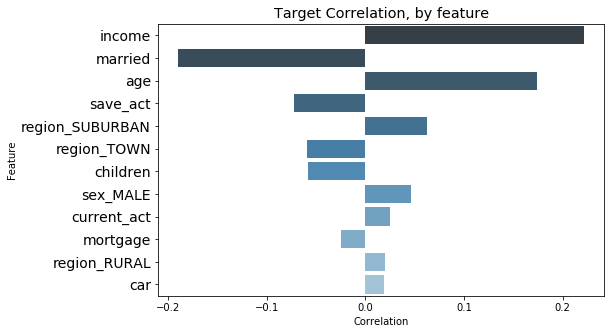

In [11]:
# index contains series values
y_labels = target_corr.index

# set fig axis properies
fig, ax = plt.subplots(figsize=(8, 5))
ax.title.set_text('Target Correlation, by feature');
ax.title.set_size('x-large');
ax.set(xlabel='Correlation', ylabel='Feature');
ax.set_yticklabels(y_labels, fontsize=14);

# plot chart
sns.barplot(x=target_corr, y=y_labels, palette="Blues_d", ax = ax);

Now let's examine the correlation *between* features.

- `age` and `income` are highly correlated with each other (0.8).
- `region` encoded columns have weak negative correlation with each other (as we'd expect)
- `save_act` is weakly correlated with `age` and `income`. seems logical.
- remaining features appear uncorrelated.

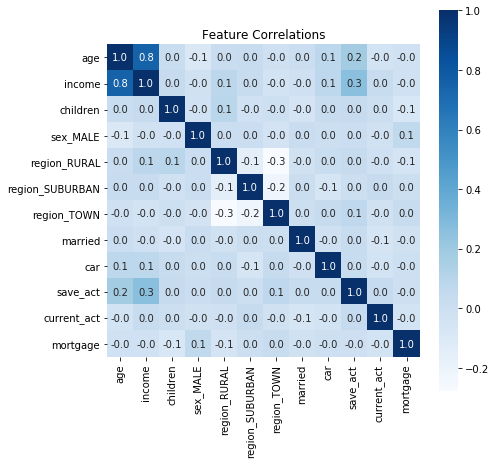

In [12]:
# calc correlations across features
corr = X.corr()

# plot correlations
fig, ax = plt.subplots(figsize=(7, 7));
ax.title.set_text('Feature Correlations');
sns.heatmap(corr, square = True, cmap = 'Blues', fmt = '.1f', ax = ax, annot = True);

Now let's split the data into train-validate-test sets (80-10-10).  Create a validation set for evaluation of hyper parameters.

- First split into train-test @ 90-10.
- Then split train into train-valid @ 80-10 *(0.90 * (1/9) = 0.1)*

In [13]:
# split into train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

# split train into train-validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = (1/9), random_state = 0)

Verify size of each dataset

In [14]:
# verify size of train/valid/test splits
print(len(X_train), '- # obs: training')
print(len(X_valid), ' - # obs: validation')
print(len(X_test), ' - # obs: test')

480 - # obs: training
60  - # obs: validation
60  - # obs: test


## Create & Compare models using Random Forest and Decision Trees

### Random Forest

There are a number of hyper parameters that we'll want to tune when building our Random Forest model.  To pass the hyper parameters into our model input, we'll structure them as dictionaries (which `sklearn` accepts).

Specifically, we'll create an array of hyperparameter dictionaries by cross-joining the sets of hyper parameters we would like to try.

First, specify hyper parameters to tune.

- `max_features`: max # of features included in each tree (default = 'sqrt')
- `min_samples_leaf`: min # of observations a node can have (default = 1)
- `max_depth`: max # of layers the tree can go to (default = unlimited)

For each hyperparameter, we'll try 3 variations.

- max_features = \['sqrt', 50\%, 75\%\]
- min_samples_leaf = \[1, 10, 30\]
- max_depth = \[unlimited, 3, 5\]

*NB - code source for Cartesian product: [stackoverflow: Cartesian product of dictionaries](https://stackoverflow.com/questions/15211568/combine-python-dictionary-permutations-into-list-of-dictionaries)*

In [15]:
# designate hyper param combinations to attempt
hyper_space = {'max_features': ['sqrt', 0.5, 0.75], 
               'min_samples_leaf': [1, 10, 30],
               'max_depth': [None, 3, 5]}

# crossjoin (cartesian product) to create array of dicts
hypers = [dict(zip(hyper_space, x)) for x in product(*hyper_space.values())]

# model cnt
print('# of hyper param combinations to try:', len(hypers))

# of hyper param combinations to try: 27


Now we'll loop through each set of hyper parameters, fitting on the train data and prediction on the validation data. With a 3x3x3 tune-grid we'll be testing out 27 models.

When we initialize the random forest classifier, we'll specify to run on all processors (`n_jobs = -1`), with 50 trees in each forest (`n_estimators = 50`).

In each loop, we'll store the results and keep the model with the highest accuracy on the validation set.  In total this should take 10-15 seconds to run.

In [16]:
# create empty df to store model results
rf_results = pd.DataFrame(columns=['max_features', 'min_samples_leaf', 'max_depth', 'accuracy'])

# loop through each set of hyper parameters
for hyper in hypers:

    # initialize rf classifier (** to load dict as args)
    rf = rfc(n_jobs = -1, n_estimators = 50, verbose = False, random_state = 99, **hyper)
    
    # fit classifier on train set
    rf.fit(X_train, y_train)
    
    # make predictions on validation set (and calculate accuracy)
    y_valid_hat = rf.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_valid_hat)
    
    # store results in df
    rf_results = rf_results.append(pd.DataFrame({
        'max_features': hyper['max_features'], 
        'min_samples_leaf': hyper['min_samples_leaf'],
        'max_depth': hyper['max_depth'],
        'accuracy': [accuracy]
    }))

Note that the `None` value in `max_depth` is treated as `null` in our df.

In [17]:
# rf_results.info()

We replace those `None` values in `max_depth` with the string `"None"` for plotting.

In [18]:
rf_results['max_depth'] = rf_results['max_depth'].fillna('None')

Visualize the results from hyper parameter tuning.

- In general, the worse models tended to be those with combinations of `depth = 3`, `max_features = 'sqrt'`, and/or `min_samples_leaf = 30`.
- The better models, tended to have more features, greater depth, and smaller leaf nodes requirements.

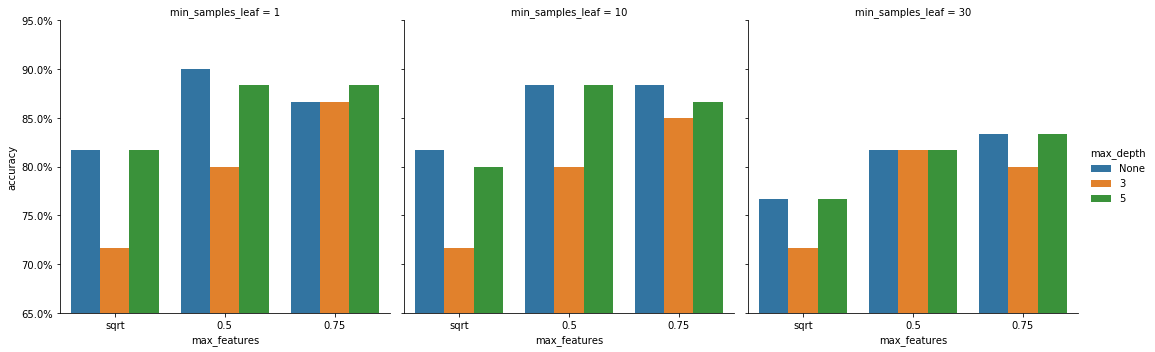

In [19]:
# specify axis
ax = sns.catplot(data = rf_results, 
                 x = 'max_features', 
                 hue = 'max_depth', 
                 col = 'min_samples_leaf',
                 y = 'accuracy', 
                 kind = 'bar',
                 ci = None);

# y axis limits
plt.ylim(0.65, 0.95)

# loop thru subplots & format axis as percentage
from  matplotlib.ticker import PercentFormatter
for subplot in ax.axes.flat:
    subplot.yaxis.set_major_formatter(PercentFormatter(1))

In fact, our best model included up to half of features in each tree with no limit on depth or leaf size.

In [20]:
# winning model
rf_results.nlargest(1, ['accuracy']) 

,max_features,min_samples_leaf,max_depth,accuracy
0,0.5,1,None,0.9


We'll re-train one last time to keep our best model from above.

In [21]:
# initalize w hyper params from best model
rf = rfc(n_jobs = -1, 
         n_estimators = 50, 
         verbose = False, 
         random_state = 99,
         max_features = 0.5,
         min_samples_leaf = 1,
         max_depth = None
        )

# fit model
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=0.5, n_estimators=50, n_jobs=-1,
                       random_state=99, verbose=False)

### Decision Tree

For our decision tree model, we'll use Gini, since that is the default loss criteria used in the random forest classifier (which we kept).

Let's specify hyper parameters to tune.  We'll use the same hyper parameters as in our random forest model, except swapping `max_features` out for `max_leaf_nodes`

- `max_leaf_nodes`: max # of total nodes our tree can have (default = unlimited)
- `min_samples_leaf`: min # of observations a node can have (default = 1)
- `max_depth`: max # of layers the tree can go to (default = unlimited)

For each, we'll try 3 variations.

- max_leaf_nodes = \[5, 15, 25\]
- min_samples_leaf = \[1, 10, 30\]
- max_depth = \[unlimited, 3, 5\]

In [22]:
# designate hyper param combinations to attempt
hyper_space = {'max_leaf_nodes': [5, 15, 25], 
               'min_samples_leaf': [1, 10, 30],
               'max_depth': [None, 3, 5]}

# crossjoin (cartesian product) to create array of dicts
hypers = [dict(zip(hyper_space, x)) for x in product(*hyper_space.values())]

# model cnt
print('# of hyper param combinations to try:', len(hypers))

# of hyper param combinations to try: 27


Similarly to tuning our Random Forest, we'll loop through our hyperparameters (fitting on train, and predicting on validation).

When we initialize the classifier, we'll only specify which loss function we want to use (Gini).

We'll store the results as we go and keep the model with the highest accuracy on the validation set.  This should run instantly (much less computation than Random Forest since each model is only 1 tree... not a whole forest of them!).

In [23]:
# create empty df to store model results
tree_results = pd.DataFrame(columns=['max_leaf_nodes', 'min_samples_leaf', 'max_depth', 'accuracy'])

# loop through each set of hyper parameters
for hyper in hypers:

    # initialize tree classifier (** to load dict as args)
    tree = DecisionTreeClassifier(criterion = 'gini', random_state = 99, **hyper)
    
    # fit classifier on train set
    tree.fit(X_train, y_train)
    
    # make predictions on validation set (and calculate accuracy)
    y_valid_hat = tree.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_valid_hat)
    
    # store results in df
    tree_results = tree_results.append(pd.DataFrame({
        'max_leaf_nodes': hyper['max_leaf_nodes'], 
        'min_samples_leaf': hyper['min_samples_leaf'],
        'max_depth': hyper['max_depth'],
        'accuracy': [accuracy]
    }))

Here we'll also need to replace `None` values in `max_depth` with the string"`None"` (otherwise they are treated as `null`).

In [24]:
tree_results['max_depth'] = tree_results['max_depth'].fillna('None')

Let's also visualize these results.

- Unlike in the random forest tuning, it appears that relative accuracy associated with the hyper parameter values are sometimes dependent on the *other* hyper parameter values.
  - Ex: when limiting to 5 nodes, `max_depth = 3` works best.  However, at other hyper parameter values, that limitation on depth is no longer helpful.

- In general, it appears that allowing more depth, nodes and smaller leaf sizes works best.

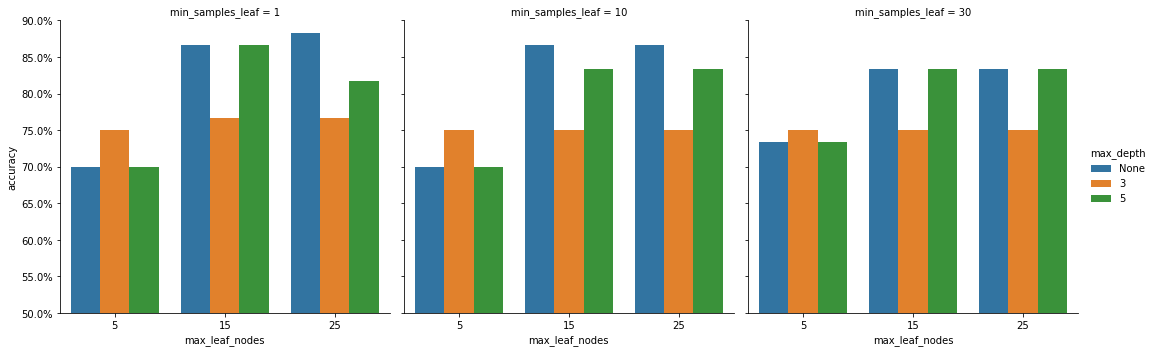

In [25]:
# specify axis
ax = sns.catplot(data = tree_results, 
                 x = 'max_leaf_nodes', 
                 hue = 'max_depth', 
                 col = 'min_samples_leaf',
                 y = 'accuracy', 
                 kind = 'bar',
                 ci = None);

# y axis limits
plt.ylim(0.50, 0.90)

# loop thru subplots & format axis as percentage
from  matplotlib.ticker import PercentFormatter
for subplot in ax.axes.flat:
    subplot.yaxis.set_major_formatter(PercentFormatter(1))

And sure enough, our best model was the one seeking the most flexibility.

In [26]:
# winning model
tree_results.nlargest(1, ['accuracy']) 

,max_leaf_nodes,min_samples_leaf,max_depth,accuracy
0,25,1,None,0.883333


Re-train once more to fit to our best model.

In [27]:
# initalize w hyper params from best model
tree = DecisionTreeClassifier(
    criterion = 'gini',
    random_state = 99, 
    max_leaf_nodes = 25,
    min_samples_leaf = 1,
    max_depth = None
    )

# fit model
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=25, random_state=99)

### Compare the models

#### Validation Accuracy

Earlier we looked individually at the best performing models on the validation set.  Now let's bring that comparison side-by-side.

We see both models did better at max depth and min leaf size.  The random forest only built each tree using half of our features, while the decision tree capped the max # of nodes at 25 (while using **all** features).

We see that on our validation set, the Random Forest performed slightly better.

In [28]:
# best random forest model
print("\nRandom Forest")
display(rf_results.nlargest(1, ['accuracy'])) 

# best decision tree model
print("\nDecision Tree")
display(tree_results.nlargest(1, ['accuracy']))


Random Forest


,max_features,min_samples_leaf,max_depth,accuracy
0,0.5,1,None,0.9



Decision Tree


,max_leaf_nodes,min_samples_leaf,max_depth,accuracy
0,25,1,None,0.883333


#### Feature Importance

First, we'll store the feature importances from each model into a dataframe and sort.  Then we'll compare them to each other.

In [29]:
# store random forest feature importance
rf_var_imp = pd.DataFrame({"feature": X_train.columns, 
                           "importance": rf.feature_importances_})
# sort (for plotting)
rf_var_imp = rf_var_imp.sort_values(by = "importance", ascending = False)

In [30]:
# store decision tree feature importance
tree_var_imp = pd.DataFrame({"feature": X_train.columns,
                             "importance": tree.tree_.compute_feature_importances()})
# sort (for plotting)
tree_var_imp = tree_var_imp.sort_values(by = "importance", ascending = False)

#### And now compare feature importance.  Let's start with similarities.

- Both models ranked `income` and `children` (respectively) as their most important features.  There's a noticeable drop off in importance of any given feature after that (for both models).
- `married` and `mortgage` seem to have similar importance in both models (4th, 5th) as does the onehot `region_TOWN` feature (7th).

#### Comparing their differences is also interesting. The two main differences are:

- The models have swapped importance of `age` and `save_act` (with Random Forest finding `age` more important)
- Random Forest was able to use *all* of the features to improve the model, while the Decision Tree ended up dropping about 5 features (~40% of them)

#### What's driving these differences?

If we recall from our within-feature correlation heatmap (near the start), age & income were pretty highly correlated (0.8).  It turns out that `income` is a modestly better predictor. 

Since random forest only has 50% of features in the model at any given time, sometimes `age` was pretty helpful (the times when `income` wasn't also included).  However, in the decision tree (where all features are included), `income` gets the top node and `age` is relegated to near the bottom.

Along those same veins, random forest was able to glean more info out of the less important features from the trees in its forest that *didn't* have the best predictors in them.

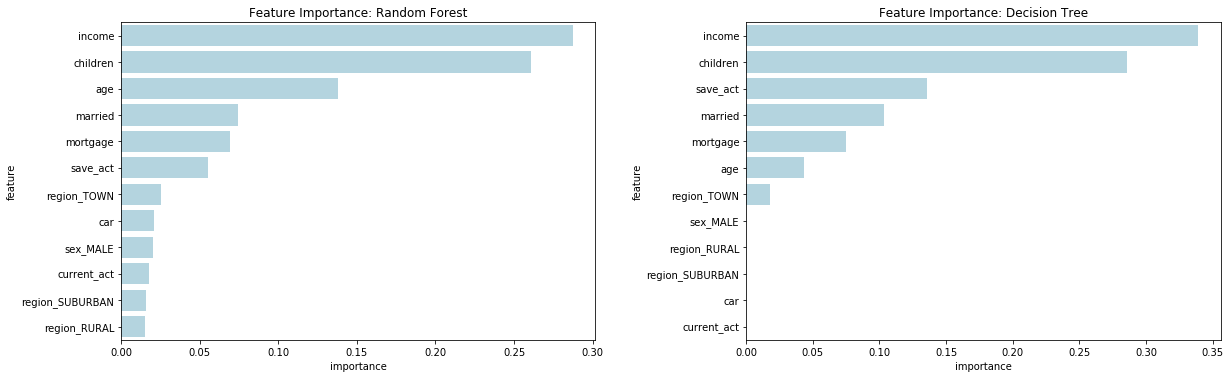

In [31]:
# set figure, axis properties
fig, ax = plt.subplots(ncols = 2, nrows = 1)
fig.set_size_inches(16, 5)
fig.tight_layout(w_pad = 12)

# rf plot
sns.barplot(x = "importance", y = "feature", data = rf_var_imp, color = "lightblue", ax = ax[0])
ax[0].title.set_text('Feature Importance: Random Forest');

# dec tree plot
sns.barplot(x = "importance", y = "feature", data = tree_var_imp, color = "lightblue", ax = ax[1])
ax[1].title.set_text('Feature Importance: Decision Tree');

#### Test Accuracy

We see accuracy on the test set is also slightly higher for the random forest model (90% vs 88.3%).  From the confusion matrices, we also see that it's higher across both classes, but most of the benefit comes from more accurate predictions on the positive class (93% vs 90%).

In [32]:
# make predictions on test set - random forest
y_test_hat_rf = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_test_hat_rf)

# make predictions on test set - decision tree
y_test_hat_tree = tree.predict(X_test)
accuracy_tree = accuracy_score(y_test, y_test_hat_tree)

# print results
print('Random Forest accuracy = ', round(accuracy_rf, 3))
print('Decision Tree accuracy = ', round(accuracy_tree, 3))

Random Forest accuracy =  0.9
Decision Tree accuracy =  0.883


Define function to cleanly present the Confusion Matrix on predictions

In [33]:
def format_cm(y, y_hat, title, labels, norm):
    
    # store (normalized) confusion matrix
    cm = np.round(confusion_matrix(y, y_hat, normalize = norm), 3)

    # configure confusion matrix plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # show plot and confusion matrix
    plt.show()
    print(cm)

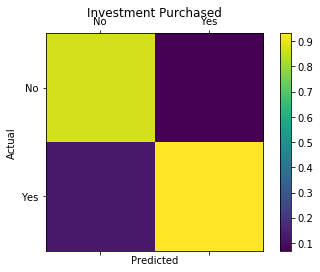

[[0.871 0.069]
 [0.129 0.931]]


In [34]:
# confusion matrix: random forest
format_cm(y_test, y_test_hat_rf, "Investment Purchased", ["No", "Yes"], "pred")

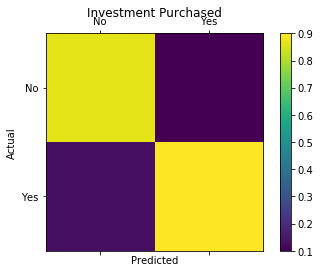

[[0.867 0.1  ]
 [0.133 0.9  ]]


In [35]:
# confusion matrix: decision tree
format_cm(y_test, y_test_hat_tree, "Investment Purchased", ["No", "Yes"], "pred")

## Summary

We have seen that both Random Forest and Decision Tree models predict well on our test data (90%, 88% respectively).  We've also seen the Random Forest model do a better job at predicting positive cases.

The difference is slight, but the Random Forest model *does* predict better.  It also incorporates more of the available features into the model.

My recommendation on model choice to the bank would be based on the sales channel they are using for their campaign.  If a list of prospects are provided up-front and can be scored in advance, then I would recommend the Random Forest as it predicts a bit better.

If the campaign is being run through a bank branch or call center, where staff are responding to customers as they approach then I would recommend the Decision Tree model.  It is a much simpler model, which can be used in real-time by asking the customer a few simple yes-no questions (which they may already be taking in anyway).  The prediction rate is slightly worse, but false positives are not particularly costly and more than made up for in simplicity.